## DATASET: HEART DISEASE

Bộ dữ liệu Heart Disease là một trong những bộ dữ liệu nổi tiếng và thường được sử dụng trong các nghiên cứu về phân tích sức khỏe, đặc biệt là các mô hình học máy liên quan đến dự đoán bệnh tim. Bộ dữ liệu này cung cấp thông tin về các yếu tố nguy cơ của bệnh tim mạch, bao gồm các đặc trưng như tuổi, giới tính, mức độ cholesterol, huyết áp và các chỉ số khác có thể liên quan đến nguy cơ mắc bệnh tim.

---

## Import

In [18]:
# Import các thư viện xử lý dữ liệu
import numpy as np
import pandas as pd

# Import các thư viện từ Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer
from ucimlrepo import fetch_ucirepo

# Import các thư viện đồ họa
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import logging

# Import các thư viện khác
import joblib
import graphviz
from graphviz import Source
from IPython.display import display

---

# I. UCI Heart Disease Dataset

## 1. Preparing the Datasets

In [19]:
def load_data():
    # Fetch dataset
    dataset = fetch_ucirepo(id=45)  # Đảm bảo fetch_ucirepo được định nghĩa
    data = dataset.data

    # Trích xuất dữ liệu
    features, labels, feature_names = data.features, data.targets, data.feature_names

    # Xử lý và ánh xạ labels
    if isinstance(labels, pd.DataFrame):
        labels = labels.values.ravel()  # Chuyển DataFrame thành mảng 1D
    labels = pd.Series(labels, name='num')
    labels = labels.map({0: "No Disease", 1: "Mild Disease", 2: "Severe Disease"})

    # Shuffle và định dạng lại labels
    features, labels = shuffle(features, labels, random_state=42)
    labels = pd.Categorical(labels, categories=["No Disease", "Mild Disease", "Severe Disease"])

    # Xử lý giá trị bị thiếu trong features
    if isinstance(features, pd.DataFrame):
        features['ca'] = features['ca'].fillna(features['ca'].mode()[0])
        features['thal'] = features['thal'].fillna(features['thal'].mode()[0])

    # Xử lý giá trị thiếu trong labels (nếu có)
    labels = pd.Series(labels)  # Chuyển lại labels thành Series
    labels = labels.fillna(labels.mode()[0])

    return features, pd.DataFrame(labels, columns=['num']), feature_names


In [20]:
def split_data(features, labels, train_size, test_size):
    return train_test_split(
        features, labels, 
        train_size=train_size, 
        test_size=test_size, 
        stratify=labels, 
        random_state=42
    )

In [21]:
def create_datasets(features, labels, split_ratios):
    return [split_data(features, labels, train_size, test_size) for train_size, test_size in split_ratios]

### 1.1 Create Training and Test Sets with Different Proportions

**Gọi hàm và khám phá dữ liệu**

In [22]:
features_shuffle, labels_shuffle, features_name = load_data()

In [23]:
print(features_shuffle.shape)
print(labels_shuffle.shape)

(303, 13)
(303, 1)


In [24]:
features_shuffle.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
179,53,1,3,130,246,1,2,173,0,0.0,1,3.0,3.0
228,54,1,4,110,206,0,2,108,1,0.0,2,1.0,3.0
111,56,1,4,125,249,1,2,144,1,1.2,2,1.0,3.0
246,58,1,4,100,234,0,0,156,0,0.1,1,1.0,7.0
60,51,0,4,130,305,0,0,142,1,1.2,2,0.0,7.0


In [25]:
labels_shuffle.head()

,num
0,No Disease
1,No Disease
2,Mild Disease
3,Severe Disease
4,Severe Disease


**Ta sẽ chia tập dữ liệu theo các tỷ lệ sau: 40/60, 60/40, 80/20, and 90/10 (train/test)**

In [26]:
features_data = features_shuffle.values
labels_data = labels_shuffle.values

# Tạo data set theo các tỷ lệ khác nhau:
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
datasets = create_datasets(features_data, labels_data, split_ratios)

### 1.2 Visualize Class Distributions

In [27]:
def visualize_distribution(datasets, proportions, labels, show_percentage=False, title="Dữ liệu phân phối", custom_colors=None):
    labels = labels.flatten() if labels.ndim > 1 else labels
    unique_labels = np.unique(labels)
    original_counts = pd.Series(labels).value_counts().reindex(unique_labels, fill_value=0).values

    colors = custom_colors or px.colors.qualitative.Plotly
    bar_width = 0.25

    for i, (train_size, test_size) in enumerate(proportions):
        _, _, train_labels, test_labels = datasets[i]
        train_labels = train_labels.flatten() if train_labels.ndim > 1 else train_labels
        test_labels = test_labels.flatten() if test_labels.ndim > 1 else test_labels

        train_counts = pd.Series(train_labels).value_counts().reindex(unique_labels, fill_value=0).values
        test_counts = pd.Series(test_labels).value_counts().reindex(unique_labels, fill_value=0).values

        if show_percentage:
            total_labels = len(labels)
            train_counts, test_counts, original_counts = train_counts / len(train_labels) * 100, test_counts / len(test_labels) * 100, original_counts / total_labels * 100

        x_positions = np.arange(len(unique_labels))

        fig = go.Figure()
        fig.add_trace(go.Bar(x=x_positions - bar_width, y=original_counts, name="Original Set", marker_color=colors[3], width=bar_width))
        fig.add_trace(go.Bar(x=x_positions, y=train_counts, name="Training Set", marker_color=colors[4], width=bar_width))
        fig.add_trace(go.Bar(x=x_positions + bar_width, y=test_counts, name="Testing Set", marker_color=colors[5], width=bar_width))

        fig.update_layout(
            title=f"{title} - Proportion {train_size}:{test_size}",
            xaxis=dict(title="Class", tickvals=x_positions, ticktext=unique_labels),
            yaxis=dict(title="Percentage" if show_percentage else "Count"),
            barmode="group", legend_title_text="Dataset"
        )
        fig.show()

# Gọi hàm
visualize_distribution(datasets, split_ratios, labels_data)

## 2. Building the Decision Tree Classifiers

### 2.1 Train Decision Tree Classifiers

In [28]:
def building_the_decision_tree(datasets, split_ratios, random_state=42, save_dir="Dataset 3/models/model_decision_tree"):
    logging.info("Starting model training...")
    os.makedirs(save_dir, exist_ok=True)
    list_models = []

    for (feature_train, _, label_train, _), (train_size, test_size) in zip(datasets, split_ratios):
        ratio = f"{int(train_size*100)}_{int(test_size*100)}"
        model = DecisionTreeClassifier(criterion="entropy", random_state=random_state)
        model.fit(feature_train, label_train)
        list_models.append(model)

        model_filename = os.path.join(save_dir, f"model_decision_tree_{ratio}.pkl")
        joblib.dump(model, model_filename)
        logging.info(f"Model saved: {model_filename}")
    
    return list_models

# Gọi hàm
list_models = building_the_decision_tree(datasets, split_ratios)

### 2.2 Visualize the Resulting Decision Tree with Graphviz


(process:9548): Pango-CRITICAL **: 18:39:46.865: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:9548): Pango-CRITICAL **: 18:39:46.865: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:9548): Pango-CRITICAL **: 18:39:46.865: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:9548): Pango-CRITICAL **: 18:39:46.881: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12444): Pango-CRITICAL **: 18:39:48.226: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12444): Pango-CRITICAL **: 18:39:48.226: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12444): Pango-CRITICAL **: 18:39:48.226: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12444): Pango-CRITICAL **: 18:39:48.226: pango_font_description_get_family: assertion 'desc != NULL' failed


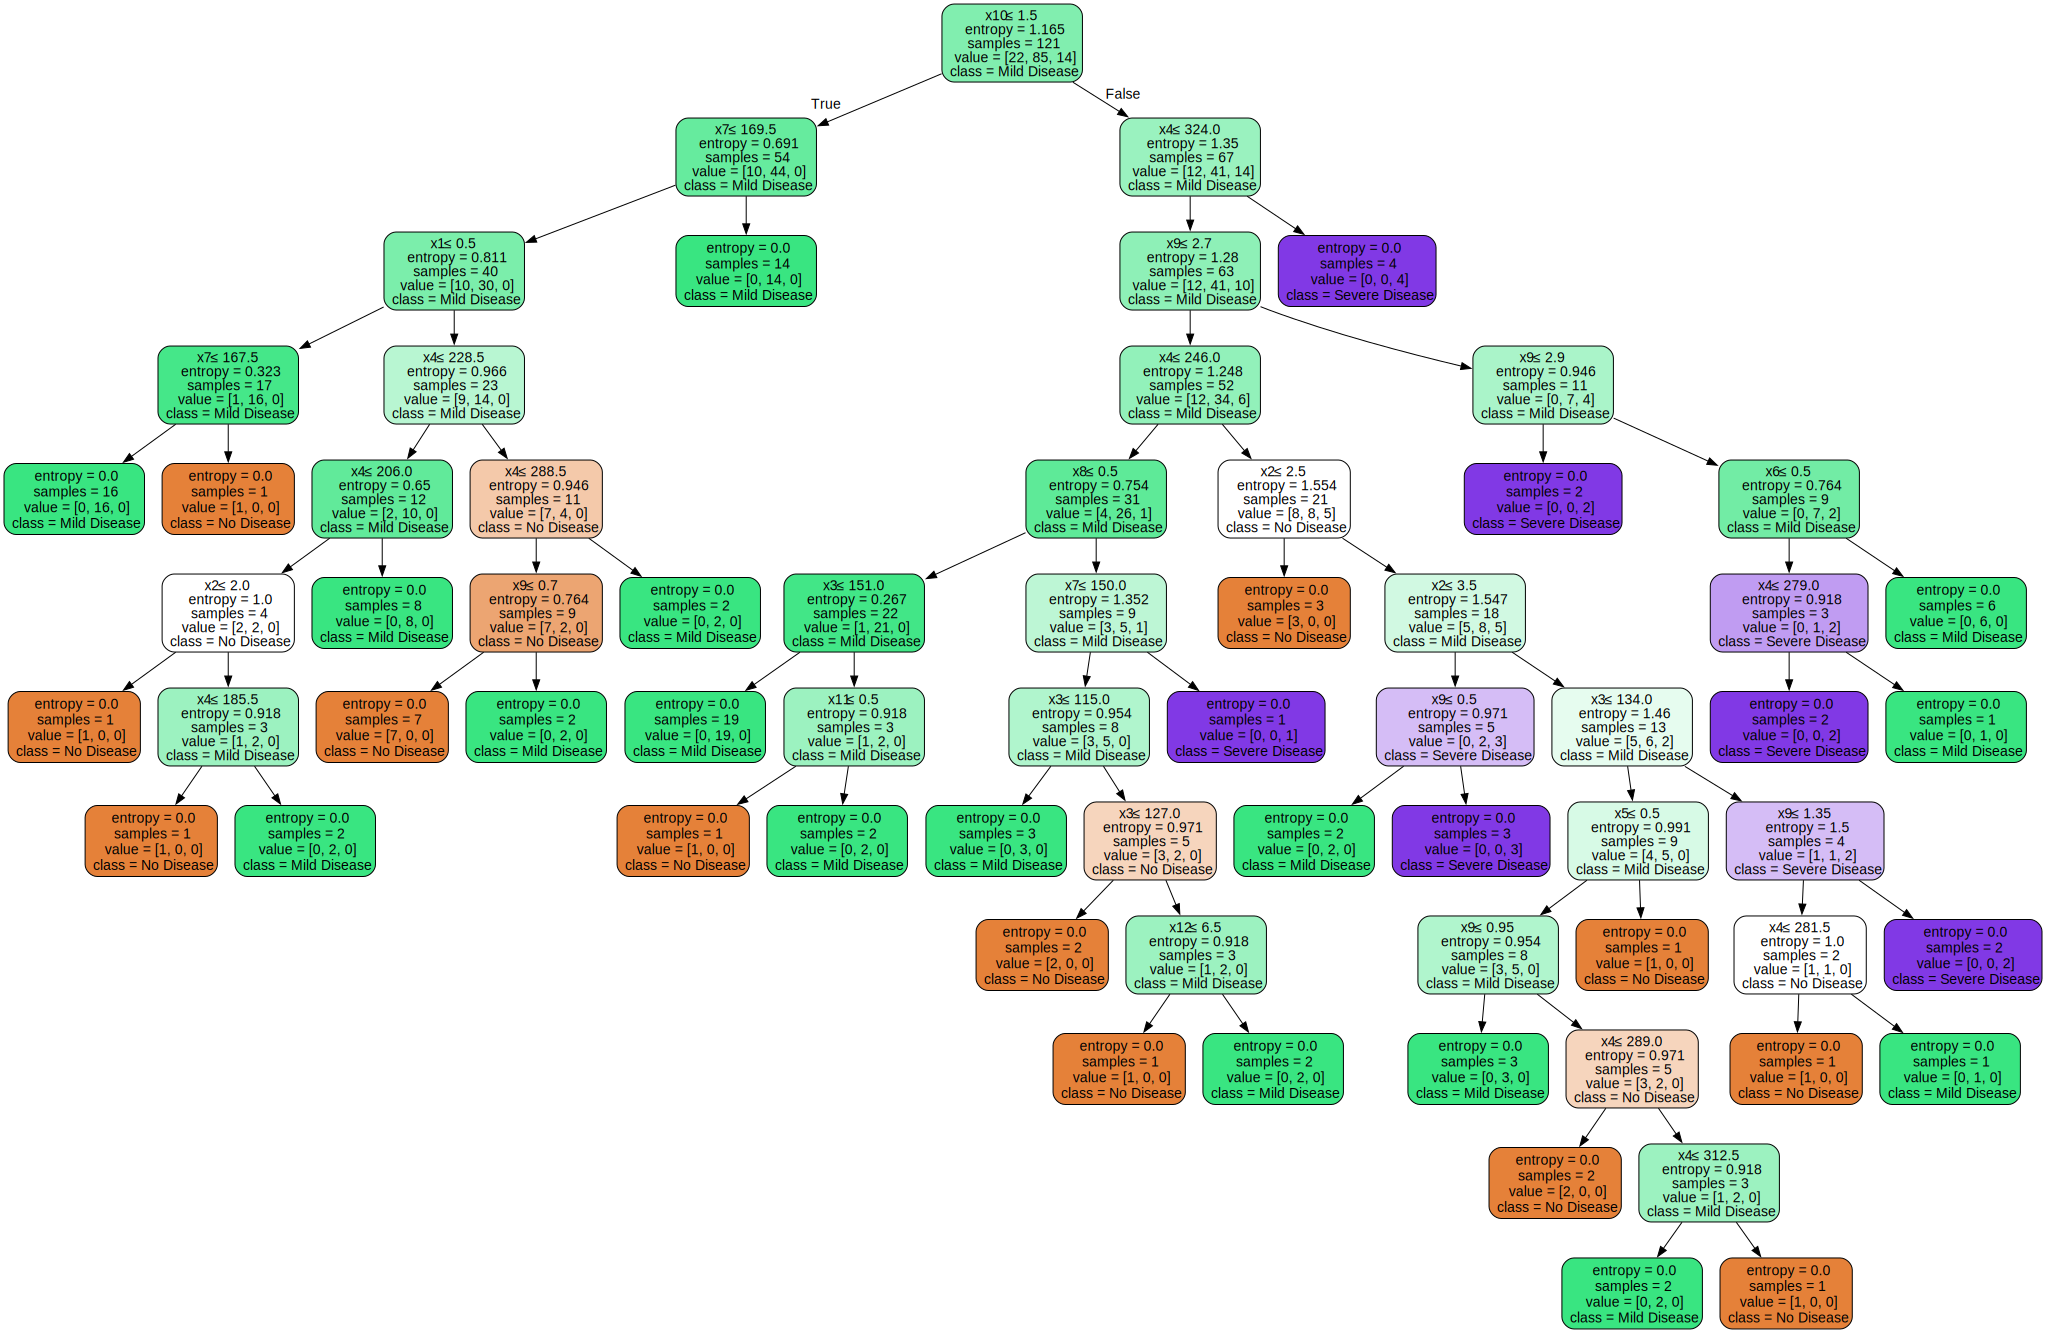

Cây quyết định với tỷ lệ 40_60 lưu vào Dataset 3/split_ratios_graphviz\graph_model_40_60.png



(process:16588): Pango-CRITICAL **: 18:39:49.348: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16588): Pango-CRITICAL **: 18:39:49.350: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16588): Pango-CRITICAL **: 18:39:49.350: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16588): Pango-CRITICAL **: 18:39:49.350: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10524): Pango-CRITICAL **: 18:39:51.087: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10524): Pango-CRITICAL **: 18:39:51.087: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10524): Pango-CRITICAL **: 18:39:51.087: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10524): Pango-CRITICAL **: 18:39:51.087: pango_font_description_get_family: assertion 'desc != NULL' failed


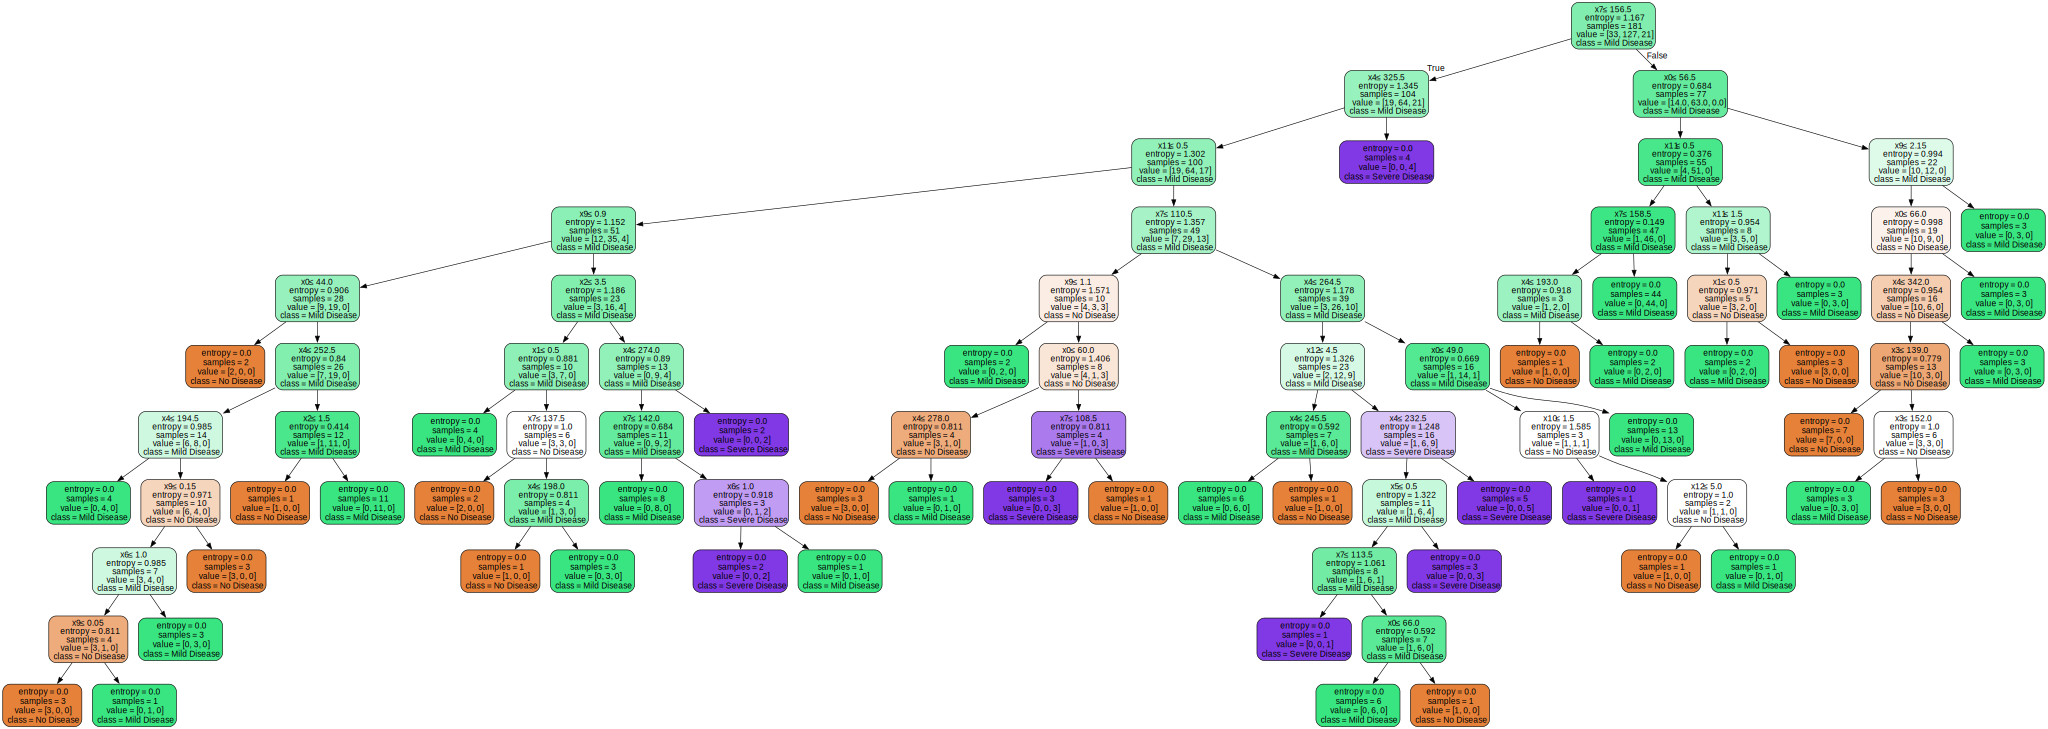

Cây quyết định với tỷ lệ 60_40 lưu vào Dataset 3/split_ratios_graphviz\graph_model_60_40.png



(process:8828): Pango-CRITICAL **: 18:39:52.099: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8828): Pango-CRITICAL **: 18:39:52.099: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8828): Pango-CRITICAL **: 18:39:52.099: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:8828): Pango-CRITICAL **: 18:39:52.099: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4244): Pango-CRITICAL **: 18:39:53.911: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4244): Pango-CRITICAL **: 18:39:53.914: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4244): Pango-CRITICAL **: 18:39:53.914: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4244): Pango-CRITICAL **: 18:39:53.914: pango_font_description_get_family: assertion 'desc != NULL' failed


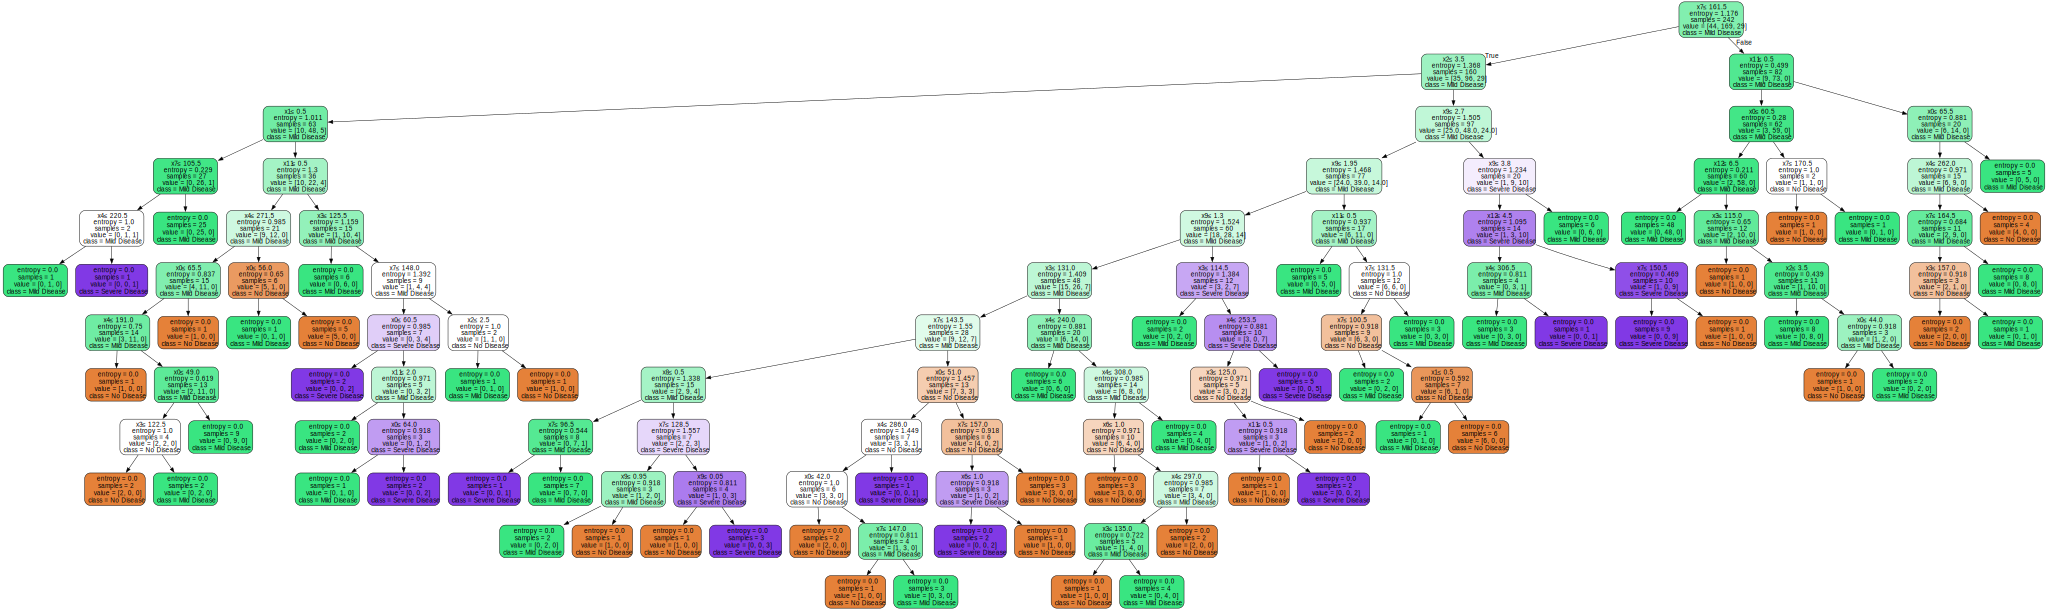

Cây quyết định với tỷ lệ 80_20 lưu vào Dataset 3/split_ratios_graphviz\graph_model_80_20.png



(process:872): Pango-CRITICAL **: 18:39:55.029: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:872): Pango-CRITICAL **: 18:39:55.029: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:872): Pango-CRITICAL **: 18:39:55.029: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:872): Pango-CRITICAL **: 18:39:55.029: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:9664): Pango-CRITICAL **: 18:39:56.966: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:9664): Pango-CRITICAL **: 18:39:56.966: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:9664): Pango-CRITICAL **: 18:39:56.966: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:9664): Pango-CRITICAL **: 18:39:56.966: pango_font_description_get_family: assertion 'desc != NULL' failed


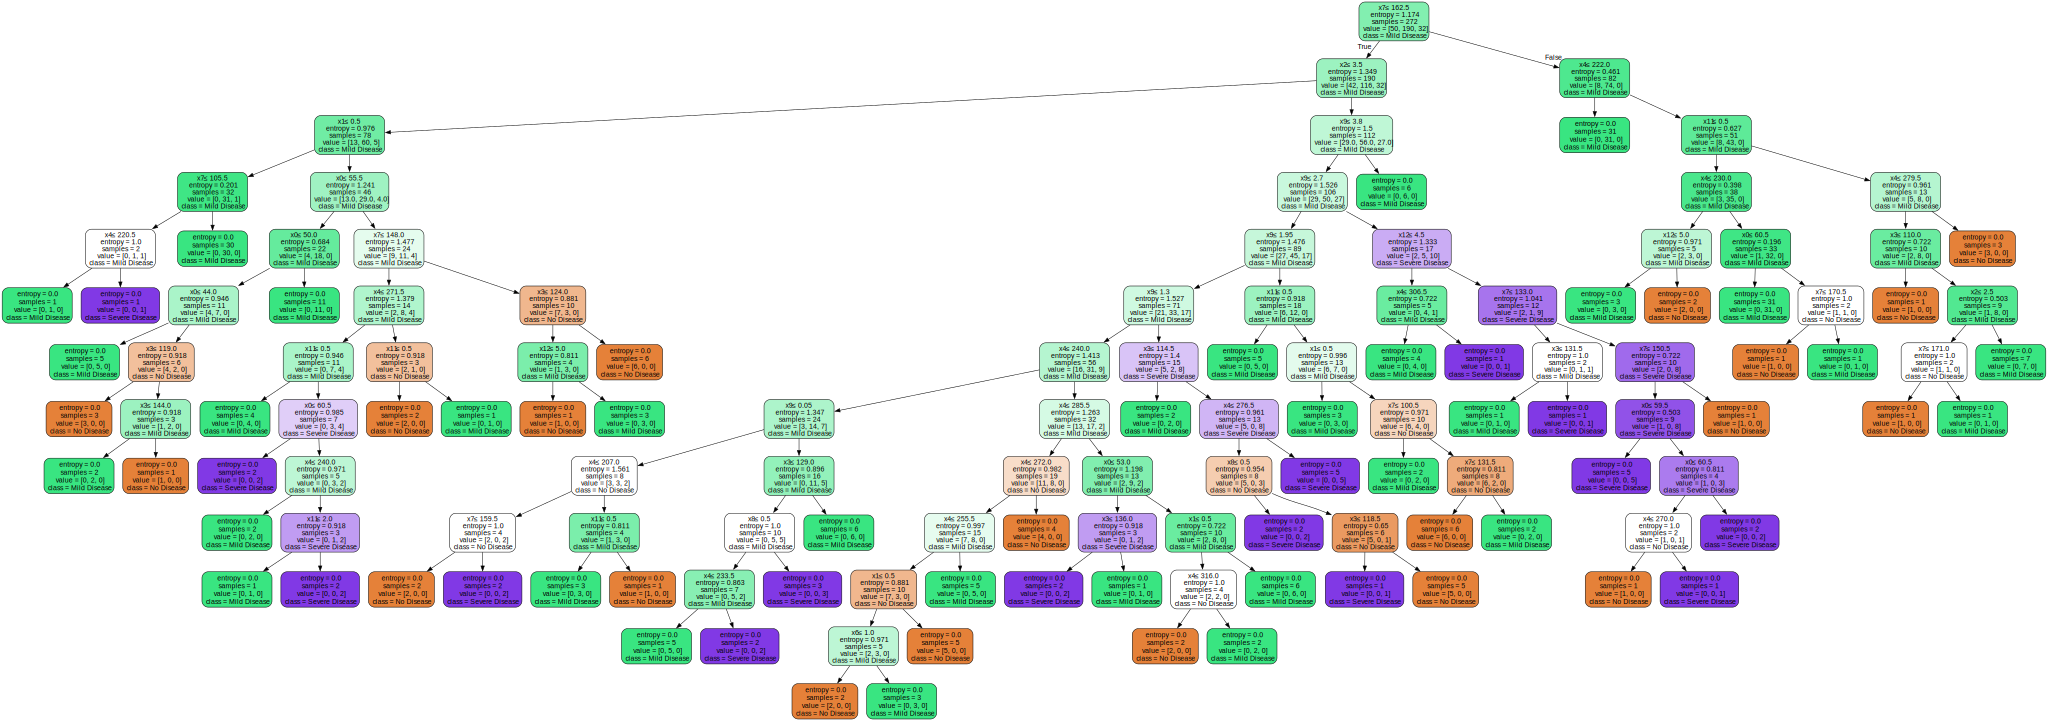

Cây quyết định với tỷ lệ 90_10 lưu vào Dataset 3/split_ratios_graphviz\graph_model_90_10.png


In [29]:
def visualize_decision_tree(list_models, split_ratios, feature_name, class_name, output_dir="Dataset 3/split_ratios_graphviz"):
    os.makedirs(output_dir, exist_ok=True)

    for model, (train_size, test_size) in zip(list_models, split_ratios):
        ratio = f"{int(train_size * 100)}_{int(test_size * 100)}"
        model_filename = os.path.join(output_dir, f"graph_model_{ratio}")

        try:
            dot_data = export_graphviz(
                model, feature_names=feature_name, class_names=class_name,
                filled=True, rounded=True, special_characters=True
            )

            graph = graphviz.Source(dot_data, engine="dot")
            graph.render(model_filename, format="png", cleanup=True)
            display(graph)
            print(f"Cây quyết định với tỷ lệ {ratio} lưu vào {model_filename}.png")

        except Exception as e:
            print(f"Lỗi hiển thị {ratio}: {e}")
            
# Gọi hàm
class_name = ["No Disease", "Mild Disease", "Severe Disease"]
visualize_decision_tree(list_models, split_ratios, features_name, class_name)

## 3. Evaluating the Decision Tree Classifiers

### 3.1 Visualize the Confusion Matrix and Classification Report

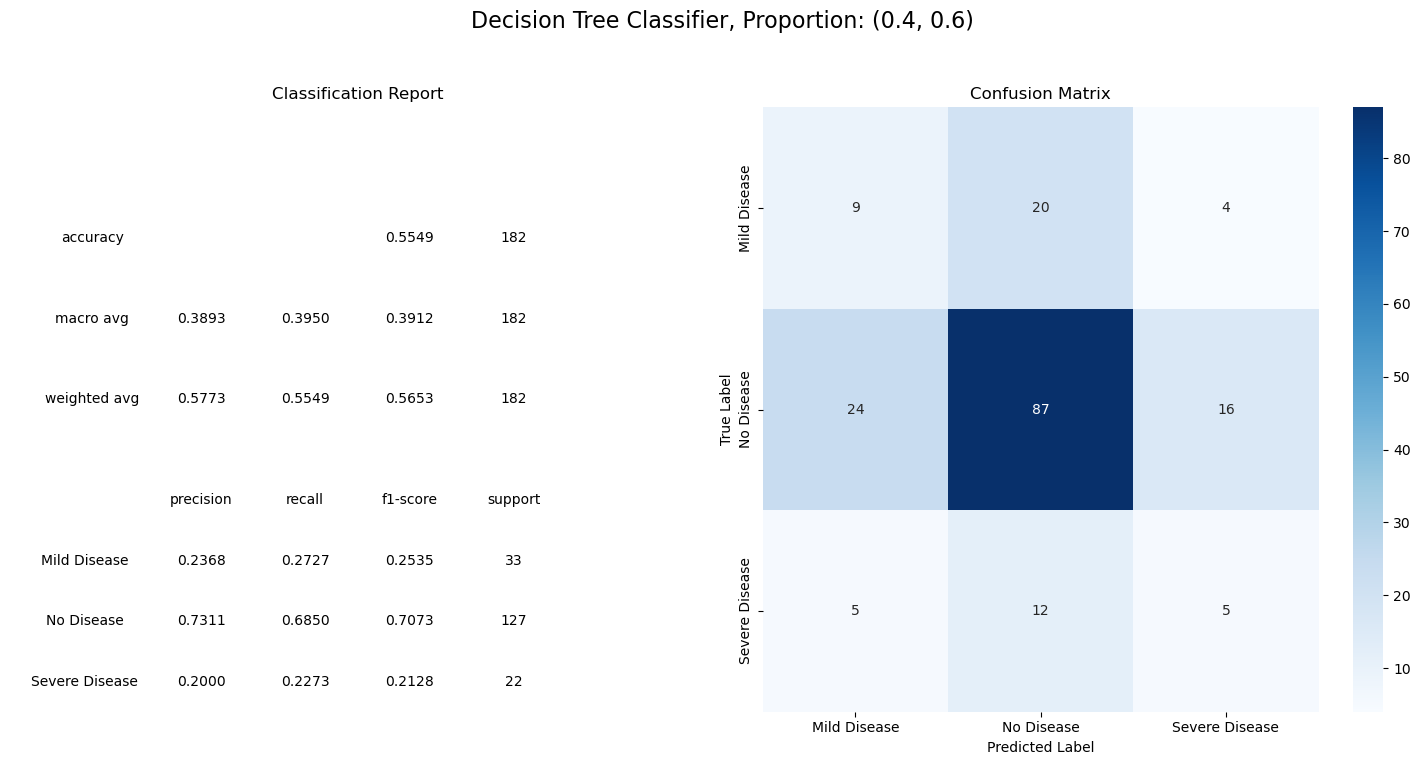

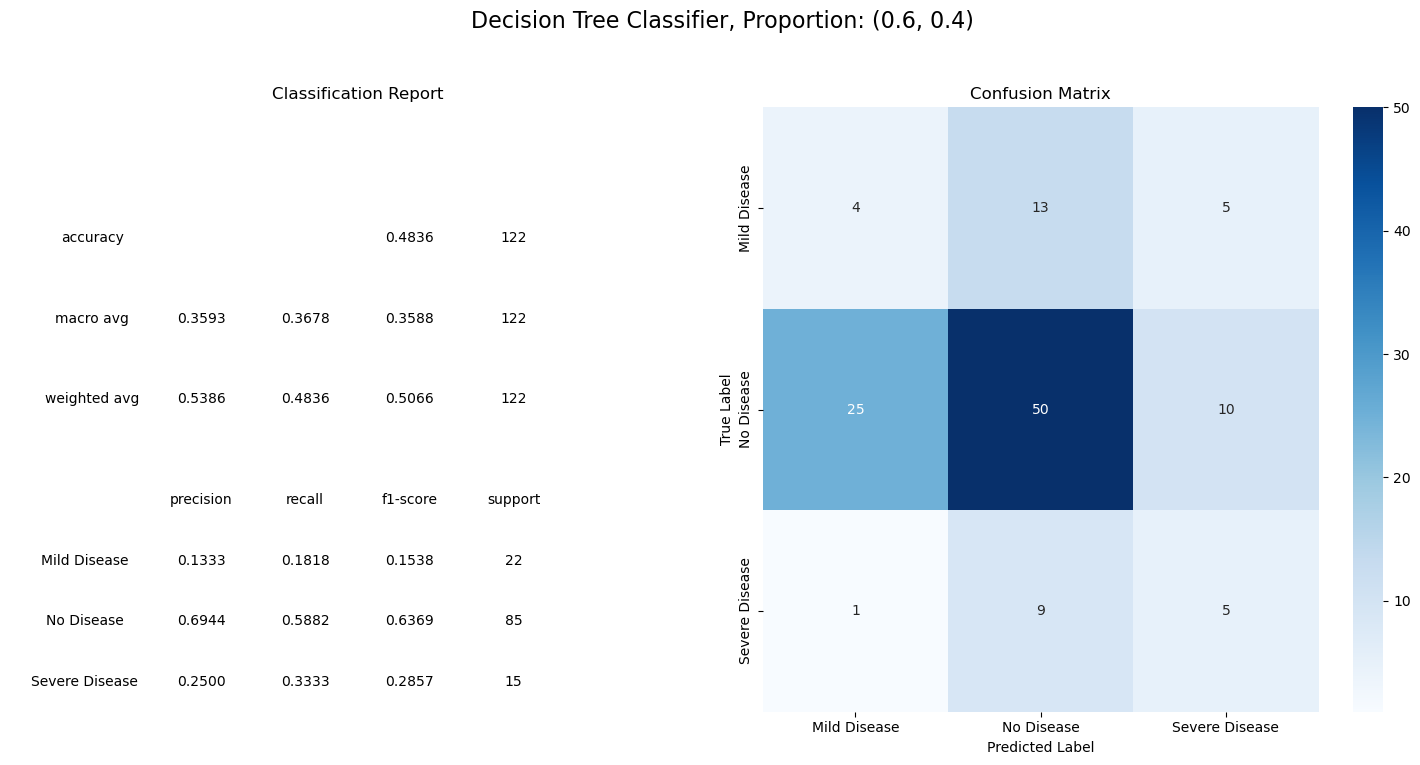

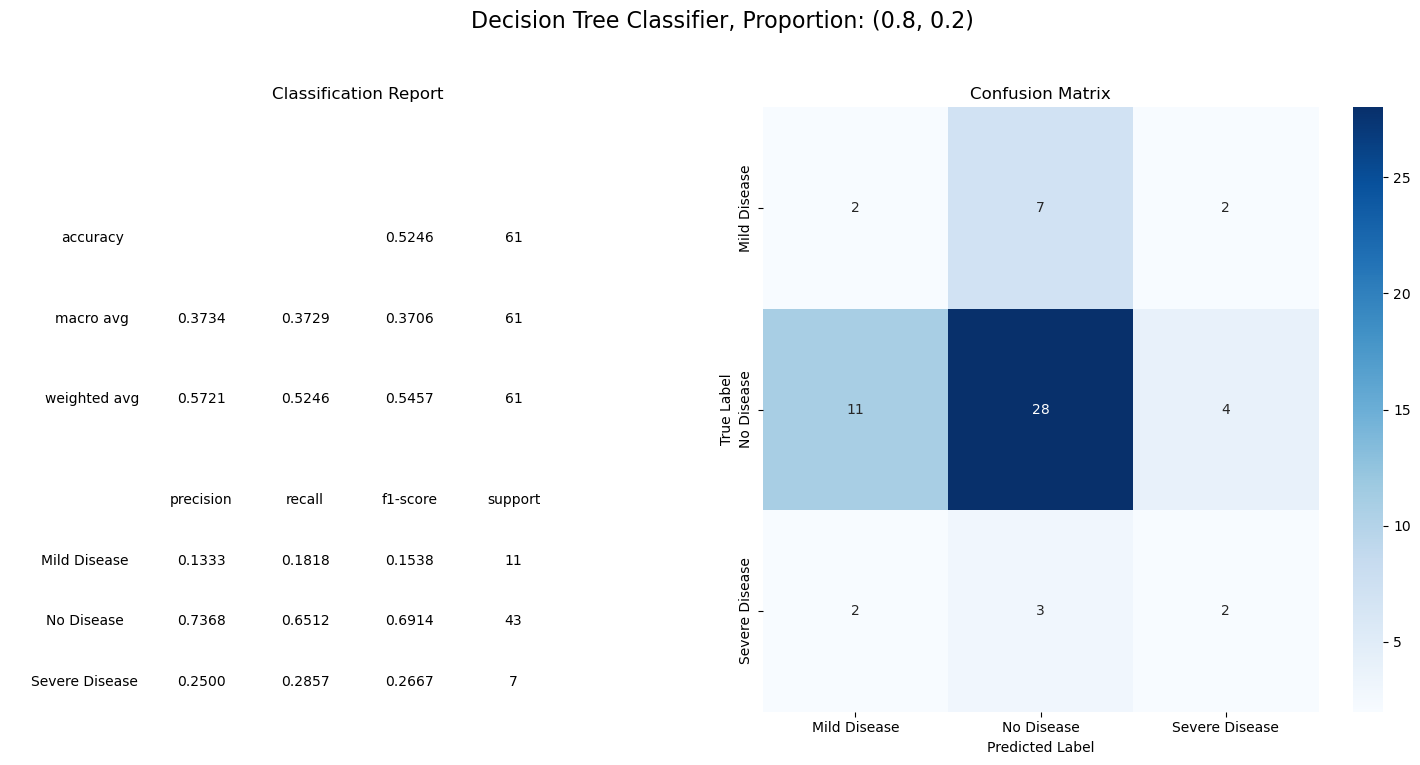

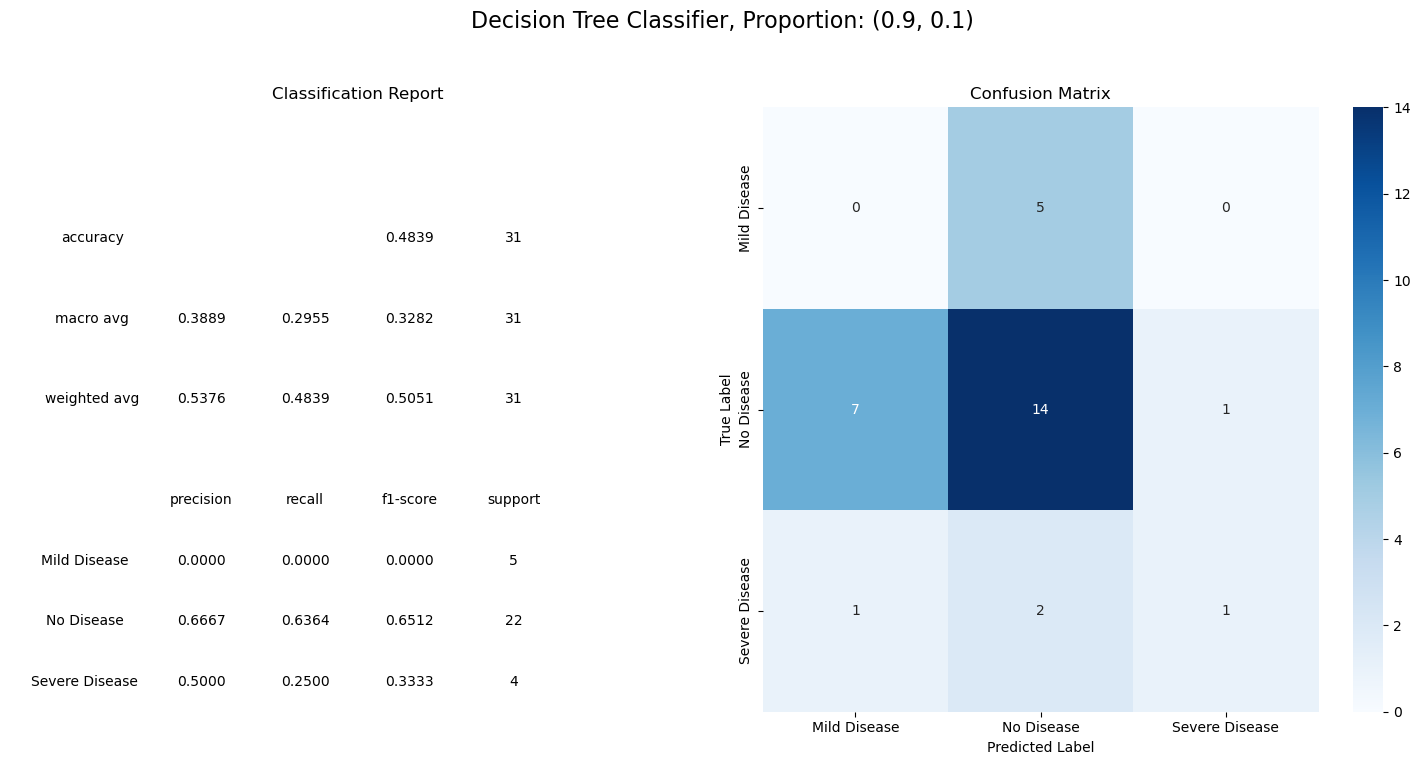

In [30]:
def create_table(data, labels, bbox, colLabels=None):
    table = plt.table(
        cellText=data,
        rowLabels=labels,
        colLabels=colLabels,
        loc="center",
        cellLoc="center",
        colWidths=[0.15]*4,  # Adjusted column widths
        bbox=bbox
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor("white")
        cell.set_height(0.1)
        cell.set_width(0.2)
        cell.set_text_props(ha="center", va="center")
    return table

def evaluating_models(list_models, datasets, split_ratios):
    output_dir = "Dataset 3/reports/evaluating_models/"
    os.makedirs(output_dir, exist_ok=True)

    for model, (feature_train, feature_test, label_train, label_test), proportion in zip(list_models, datasets, split_ratios):
        label_prediction = model.predict(feature_test)
        report = classification_report(label_test, label_prediction, zero_division=1, digits=4)
        matrix = confusion_matrix(label_test, label_prediction)

        plt.figure(figsize=(15, 8))

        # Left subplot for the classification report table
        plt.subplot(1, 2, 1)
        report_lines = report.strip().split("\n")[2:-4]
        class_labels = [' '.join(line.split()[:-4]) for line in report_lines]
        data = [line.split()[2:] for line in report_lines]
        statistical_data = [
            [" ", " "] + report.splitlines()[-3].split()[1:],
            *[line.split()[2:] for line in report.splitlines()[-2:]]
        ]
        create_table(data, class_labels, [0.2, 0., 0.6, 0.4], colLabels=["precision", "recall", "f1-score", "support"])
        create_table(statistical_data, ["accuracy", "macro avg", "weighted avg"], [0.2, 0.45, 0.6, 0.4])

        plt.axis("off")
        plt.title("Classification Report")

        # Right subplot for the confusion matrix heatmap
        plt.subplot(1, 2, 2)
        sns.heatmap(matrix, annot=True, cmap="Blues", fmt="d", cbar=True,
                    xticklabels=model.classes_, yticklabels=model.classes_, linewidths=0)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")

        # Main title and save figure
        plt.suptitle(f"Decision Tree Classifier, Proportion: {proportion}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        file_name = f"report_model_{int(proportion[0] * 100)}_{int(proportion[1] * 100)}.png"
        plt.savefig(os.path.join(output_dir, file_name))
        plt.show()

# Call the function
evaluating_models(list_models, datasets, split_ratios)

## 4. The Depth and Accuracy of a Decision Tree

### 4.1 Train the Model with a Maximum Depth for the Decision Tree

In [31]:
# Chiều sâu cần kiểm tra
list_max_depth = [2, 3, 4, 5, 6, 7, None]

In [32]:
def max_depth_model_decision_tree(datasets, list_max_depth):
    feature_train, feature_test, label_train, label_test = datasets[2]
    os.makedirs("Dataset 3/models/model_max_depth_decision_tree", exist_ok=True)

    models, accuracy_results = [], {}
    for max_depth in list_max_depth:
        model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
        model.fit(feature_train, label_train)
        accuracy_results[max_depth] = accuracy_score(label_test, model.predict(feature_test))
        joblib.dump(model, f"Dataset 3/models/model_max_depth_decision_tree/model_dt_depth_{max_depth}.pkl")
        models.append(model)

    return models, accuracy_results

# Gọi hàm
list_max_depth_model, accuracy_results = max_depth_model_decision_tree(datasets, list_max_depth)

### 4.2 Visualize Decision Trees for Different Max Depth Values


(process:11176): Pango-CRITICAL **: 18:40:03.788: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11176): Pango-CRITICAL **: 18:40:03.788: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11176): Pango-CRITICAL **: 18:40:03.788: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11176): Pango-CRITICAL **: 18:40:03.788: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16616): Pango-CRITICAL **: 18:40:04.833: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16616): Pango-CRITICAL **: 18:40:04.833: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16616): Pango-CRITICAL **: 18:40:04.833: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16616): Pango-CRITICAL **: 18:40:04.833: pango_font_description_get_family: assertion 'desc != NULL' failed


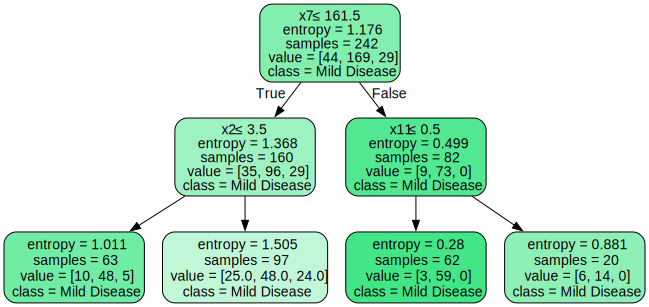

Graph saved: Dataset 3/max_depth_graphviz\graph_model_80_20_depth_2.png (max_depth=2)



(process:10612): Pango-CRITICAL **: 18:40:05.826: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10612): Pango-CRITICAL **: 18:40:05.826: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10612): Pango-CRITICAL **: 18:40:05.827: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10612): Pango-CRITICAL **: 18:40:05.827: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14856): Pango-CRITICAL **: 18:40:07.060: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14856): Pango-CRITICAL **: 18:40:07.061: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14856): Pango-CRITICAL **: 18:40:07.061: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14856): Pango-CRITICAL **: 18:40:07.061: pango_font_description_get_family: assertion 'desc != NULL' failed


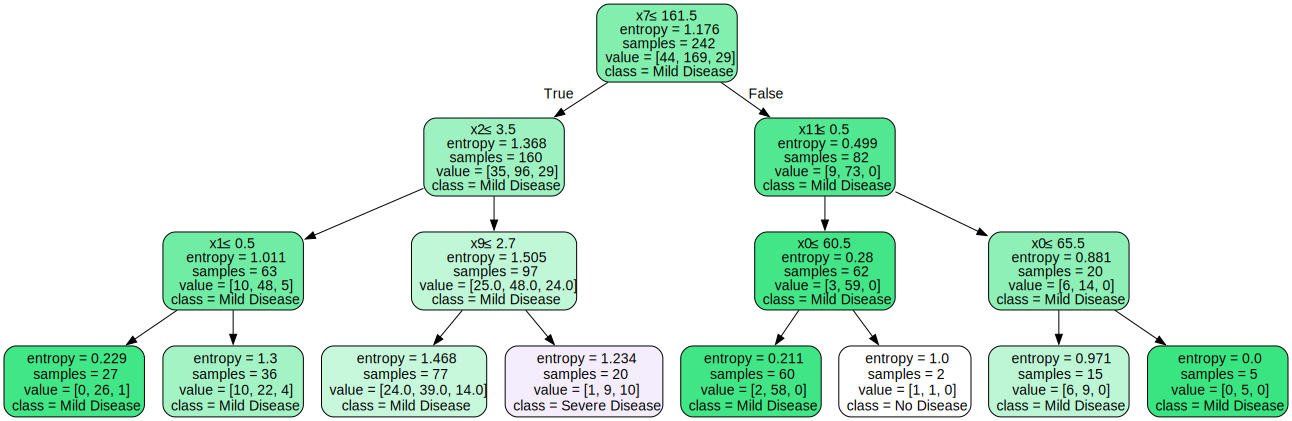

Graph saved: Dataset 3/max_depth_graphviz\graph_model_80_20_depth_3.png (max_depth=3)



(process:16012): Pango-CRITICAL **: 18:40:08.175: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16012): Pango-CRITICAL **: 18:40:08.176: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16012): Pango-CRITICAL **: 18:40:08.176: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16012): Pango-CRITICAL **: 18:40:08.176: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14256): Pango-CRITICAL **: 18:40:09.349: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14256): Pango-CRITICAL **: 18:40:09.350: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14256): Pango-CRITICAL **: 18:40:09.350: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:14256): Pango-CRITICAL **: 18:40:09.350: pango_font_description_get_family: assertion 'desc != NULL' failed


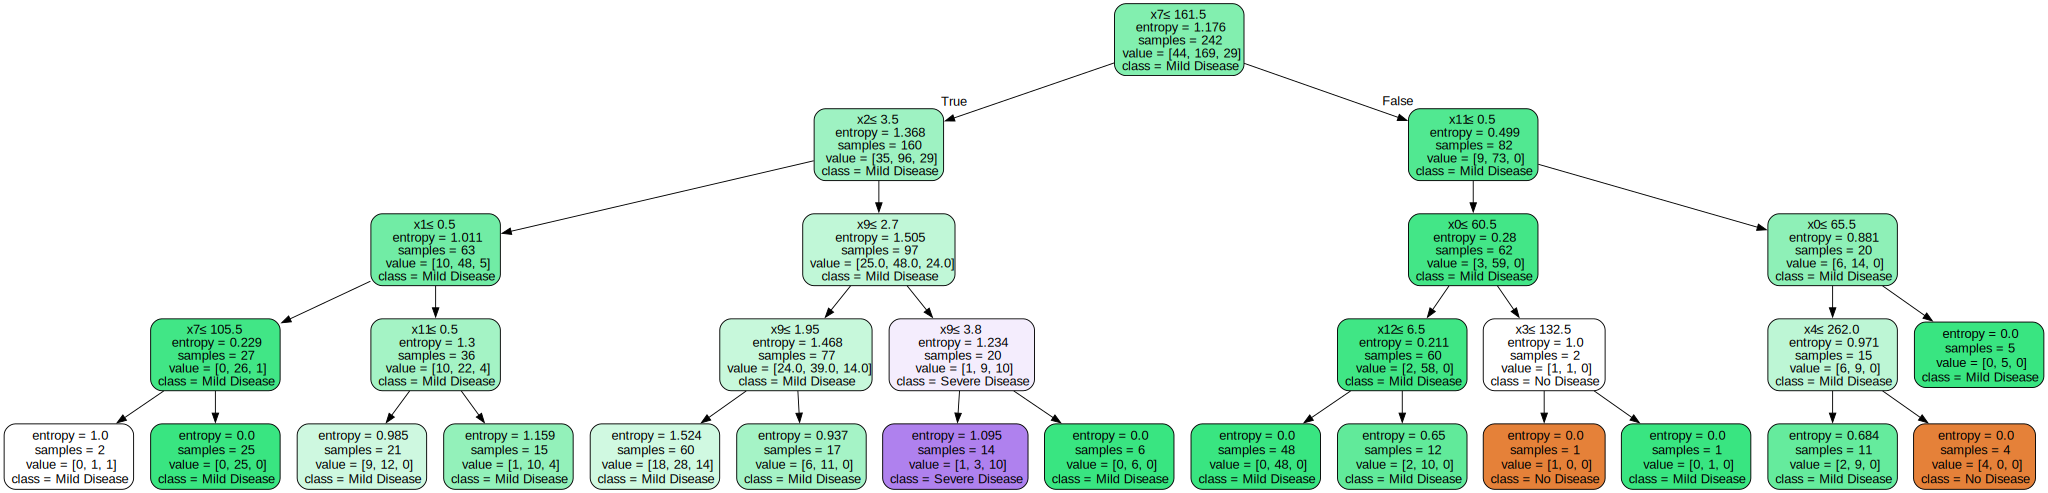

Graph saved: Dataset 3/max_depth_graphviz\graph_model_80_20_depth_4.png (max_depth=4)



(process:4904): Pango-CRITICAL **: 18:40:10.371: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4904): Pango-CRITICAL **: 18:40:10.371: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4904): Pango-CRITICAL **: 18:40:10.371: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4904): Pango-CRITICAL **: 18:40:10.371: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12340): Pango-CRITICAL **: 18:40:12.268: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12340): Pango-CRITICAL **: 18:40:12.268: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12340): Pango-CRITICAL **: 18:40:12.268: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12340): Pango-CRITICAL **: 18:40:12.268: pango_font_description_get_family: assertion 'desc != NULL' failed


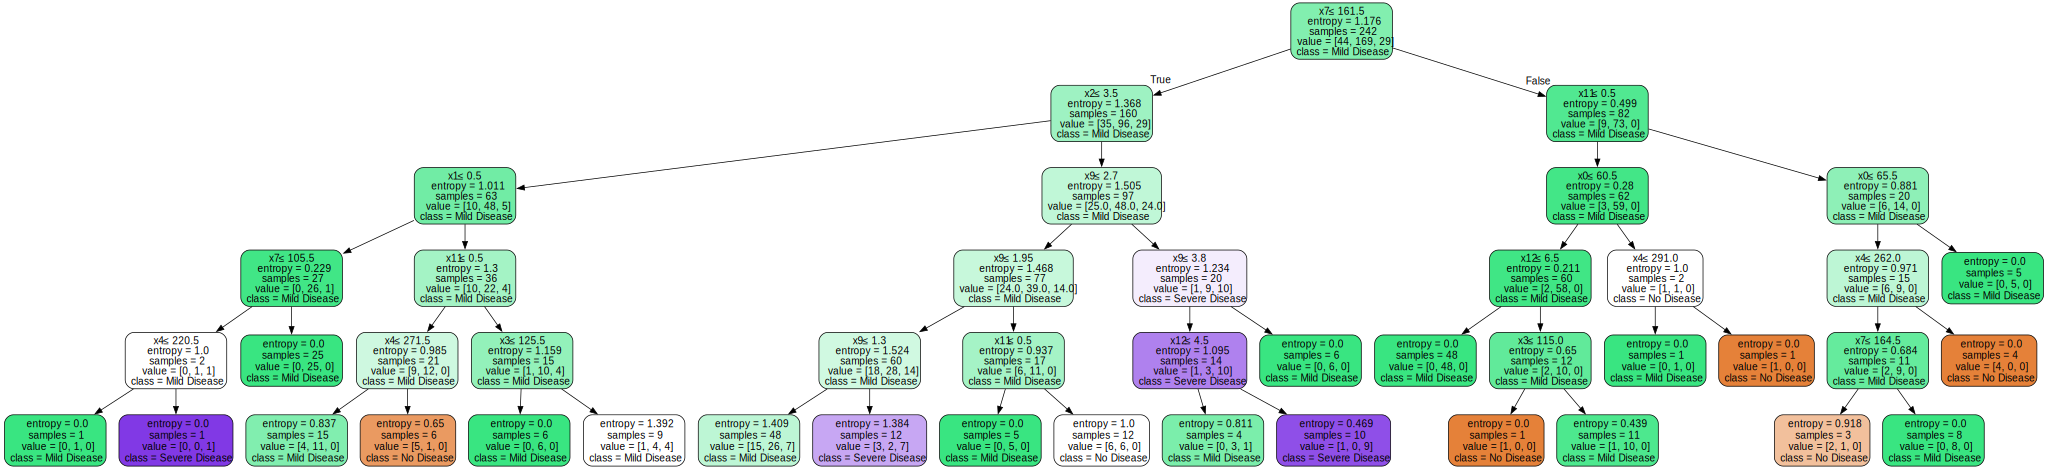

Graph saved: Dataset 3/max_depth_graphviz\graph_model_80_20_depth_5.png (max_depth=5)



(process:2068): Pango-CRITICAL **: 18:40:13.914: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:2068): Pango-CRITICAL **: 18:40:13.914: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:2068): Pango-CRITICAL **: 18:40:13.914: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:2068): Pango-CRITICAL **: 18:40:13.914: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16052): Pango-CRITICAL **: 18:40:15.869: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16052): Pango-CRITICAL **: 18:40:15.870: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16052): Pango-CRITICAL **: 18:40:15.870: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16052): Pango-CRITICAL **: 18:40:15.870: pango_font_description_get_family: assertion 'desc != NULL' failed


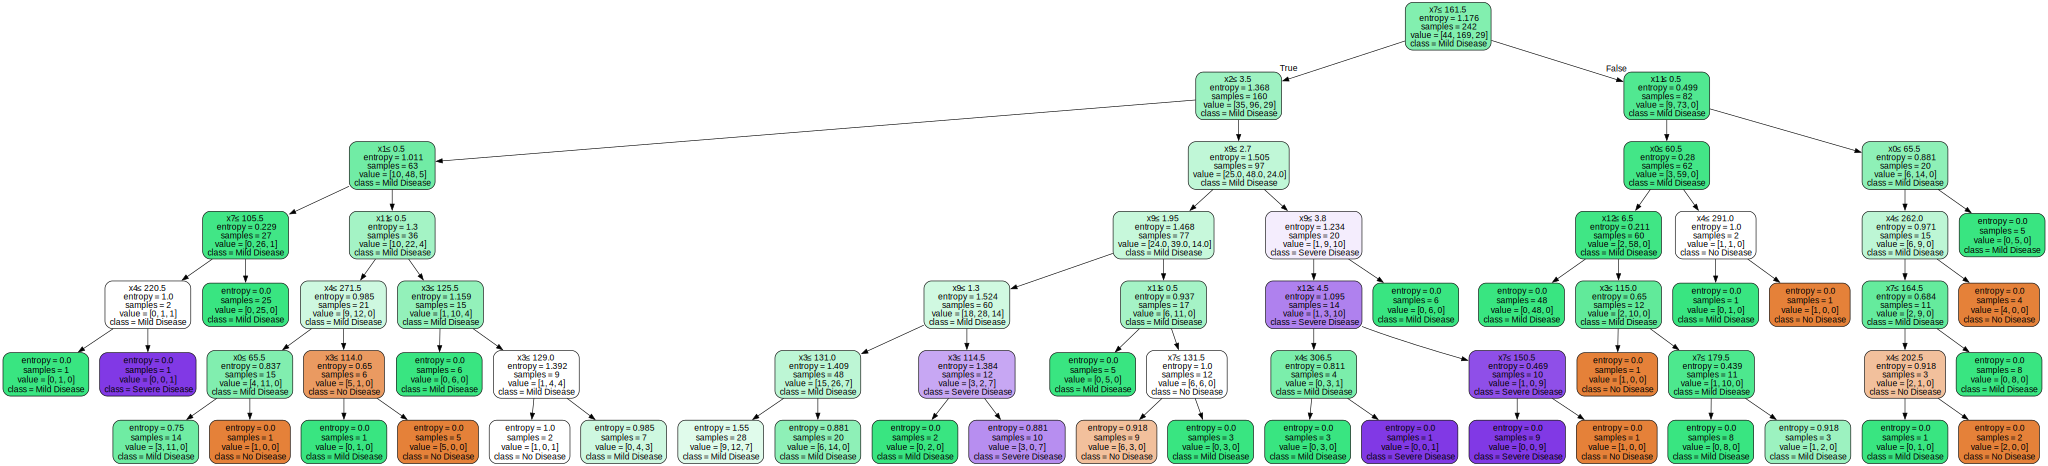

Graph saved: Dataset 3/max_depth_graphviz\graph_model_80_20_depth_6.png (max_depth=6)



(process:17300): Pango-CRITICAL **: 18:40:16.977: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:17300): Pango-CRITICAL **: 18:40:16.978: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:17300): Pango-CRITICAL **: 18:40:16.978: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:17300): Pango-CRITICAL **: 18:40:16.978: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1772): Pango-CRITICAL **: 18:40:18.594: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1772): Pango-CRITICAL **: 18:40:18.594: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1772): Pango-CRITICAL **: 18:40:18.609: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1772): Pango-CRITICAL **: 18:40:18.609: pango_font_description_get_family: assertion 'desc != NULL' failed


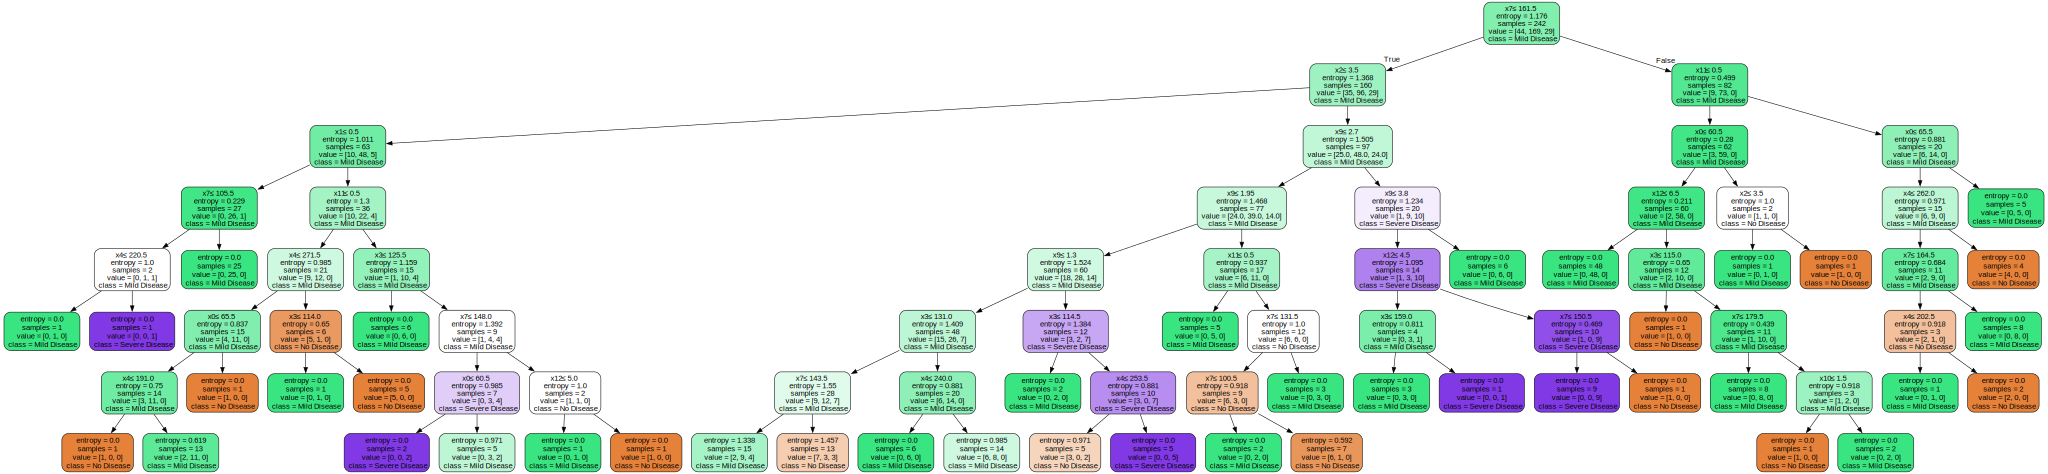

Graph saved: Dataset 3/max_depth_graphviz\graph_model_80_20_depth_7.png (max_depth=7)



(process:16116): Pango-CRITICAL **: 18:40:19.810: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16116): Pango-CRITICAL **: 18:40:19.812: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16116): Pango-CRITICAL **: 18:40:19.812: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:16116): Pango-CRITICAL **: 18:40:19.812: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11652): Pango-CRITICAL **: 18:40:21.955: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11652): Pango-CRITICAL **: 18:40:21.955: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11652): Pango-CRITICAL **: 18:40:21.955: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:11652): Pango-CRITICAL **: 18:40:21.955: pango_font_description_get_family: assertion 'desc != NULL' failed


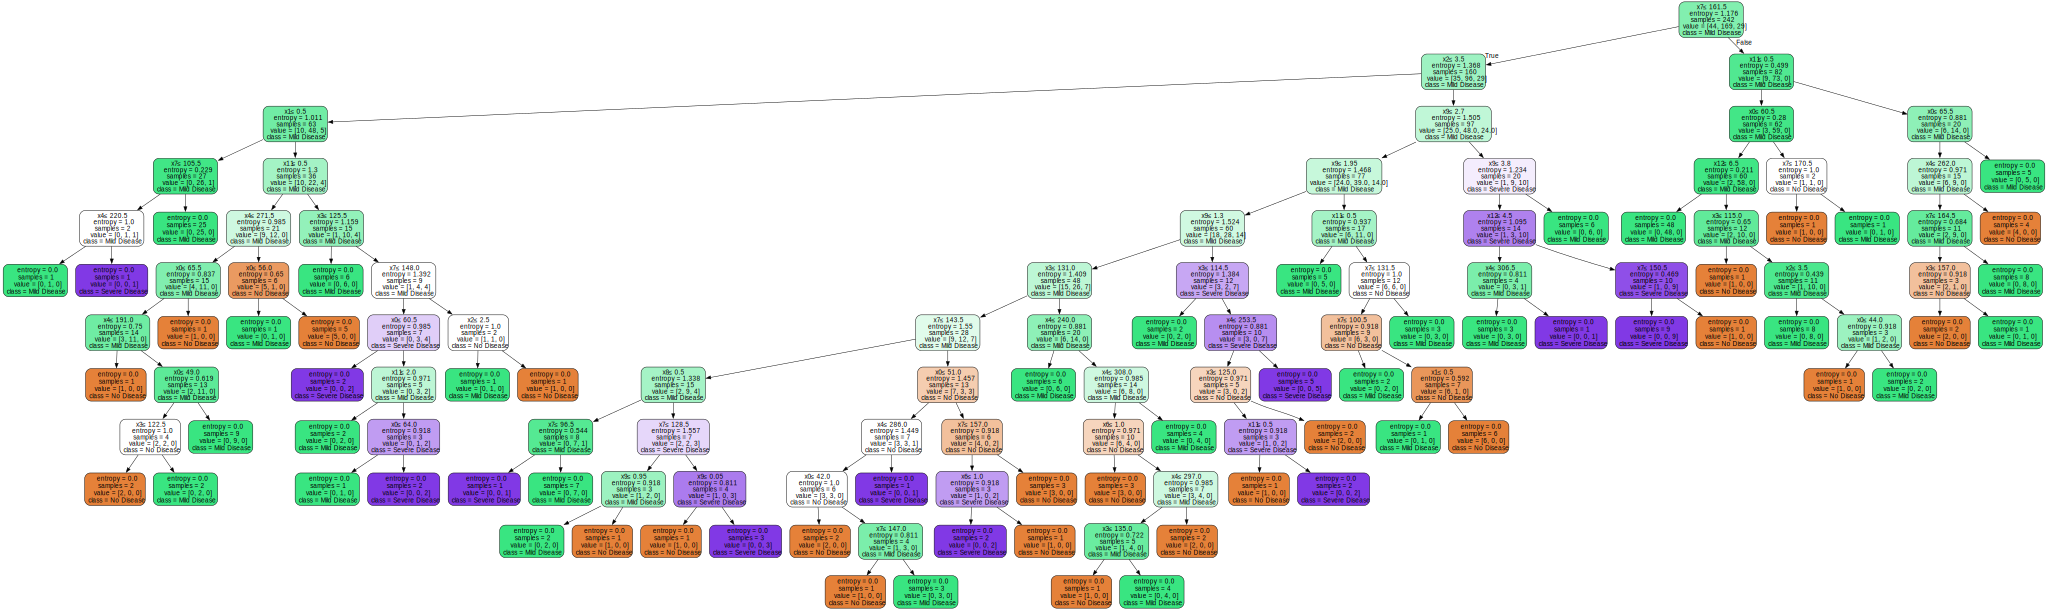

Graph saved: Dataset 3/max_depth_graphviz\graph_model_80_20_depth_None.png (max_depth=None)


In [33]:
def visualize_max_depth(models, depths, features, classes):
    output_dir = "Dataset 3/max_depth_graphviz"
    os.makedirs(output_dir, exist_ok=True)

    for model, depth in zip(models, depths):
        # Export model to Graphviz format
        graph = graphviz.Source(export_graphviz(
            model, feature_names=features, class_names=classes,
            filled=True, rounded=True, special_characters=True
        ))
        # Render and save as PNG
        filename = os.path.join(output_dir, f"graph_model_80_20_depth_{depth}")
        graph.render(filename, format="png", cleanup=True)
        display(graph)  # Display graph inline
        print(f"Graph saved: {filename}.png (max_depth={depth})")

# gọi hàm
visualize_max_depth(list_max_depth_model, list_max_depth, features_name, class_name)

### 4.3 Report of decision tree when changing the value of parameter `max_depth`

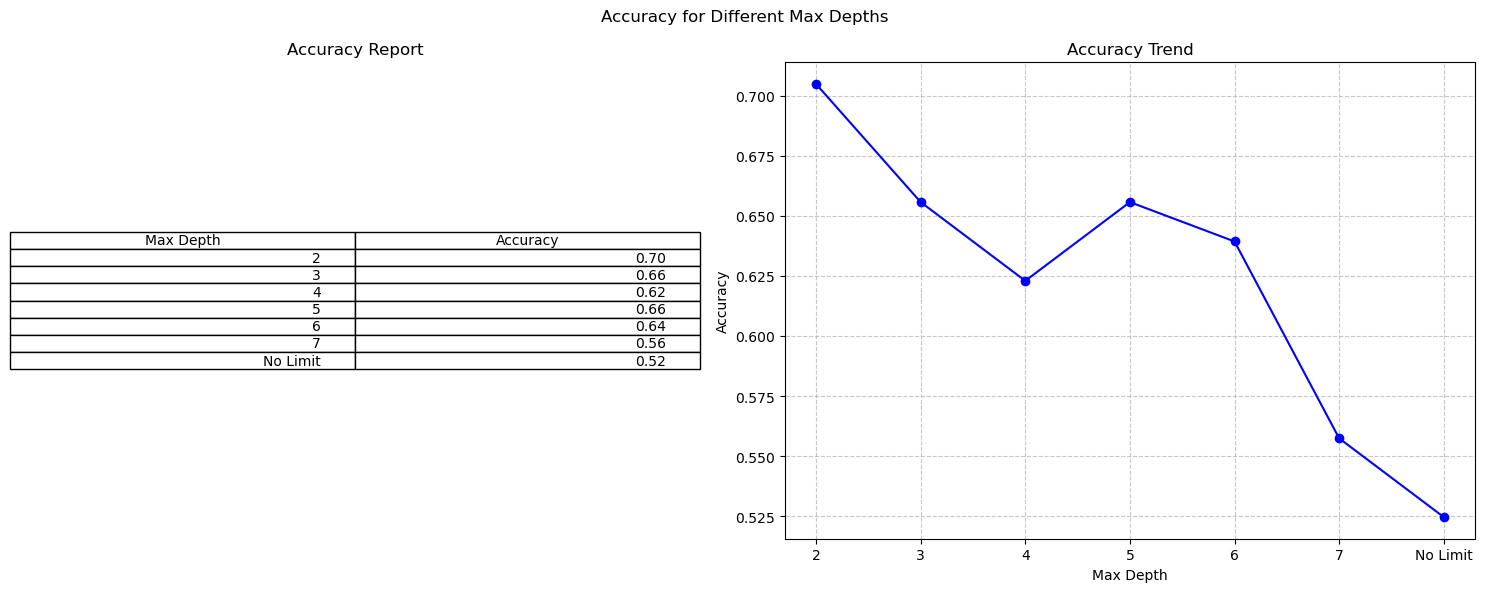

In [34]:
def plot_max_depth_accuracy(accuracy_results, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    max_depths = ["No Limit" if d is None else str(d) for d in accuracy_results.keys()]
    accuracies = list(accuracy_results.values())
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.table(cellText=[[d, f"{a:.2f}"] for d, a in zip(max_depths, accuracies)], colLabels=["Max Depth", "Accuracy"], loc="center")
    plt.axis("off")
    plt.title("Accuracy Report")

    plt.subplot(1, 2, 2)
    plt.plot(max_depths, accuracies, marker="o", color="blue")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Trend")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.suptitle("Accuracy for Different Max Depths")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Gọi hàm
output_path = f"Dataset 3/reports/max_depth_accuracy/accuracy_report.png"
plot_max_depth_accuracy(accuracy_results, output_path)